In [1]:
import haiku as hk
import jax
import jax.random as jrnd
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)

import numpy as np
import optax
import seaborn as sns
import pandas as pd

In [2]:
from modules import *
from utils import *
from training import *

In [3]:
import matplotlib.pyplot as plt

In [4]:
import pickle as p

# Model

In [5]:
#instantiate the first PRNG key
key = jrnd.PRNGKey(42)

In [6]:
#define the dimensionality of the VSA and number of samples to use
d_vsa = 1024
n_samples = 32

In [7]:
key, subkey = random.split(key)
rand_inputs = random.uniform(subkey, (n_samples, d_vsa))

In [8]:
w_init = hk.initializers.VarianceScaling(2.0, "fan_avg", "uniform")

In [9]:
class PhasorDense2(hk.Module):
    """
    Fully-connected / "Linear" layer which implements phasor activation.
    
    Sub-version of main class which returns both the complex values and their angular components. 

    """

    def __init__(self, output_size, w_init, mask_angle: float = -1.0, name=None):
        super().__init__(name=name)
        self.output_size = output_size
        self.w_init = w_init
        self.mask_angle = mask_angle
        
    def __call__(self, x, **kwargs):

        #access the weights / biases
        j, k = x.shape[-1], self.output_size
        w = hk.get_parameter("w", shape=[j, k], dtype="float", init=self.w_init)
        b = hk.get_parameter("bz", shape=[k], dtype="float", init=jnp.ones)

        #convert the phase angles to complex numbers
        pi = jnp.pi
        imag = complex(0.0, 1.0)
        xz = jnp.exp(imag * pi * x)
        #mask all inputs inside the arc of the mask angle
        if self.mask_angle > 0.0:
            mask = jnp.greater_equal(jnp.abs(x), self.mask_angle)
            xz = xz * mask
        
        #convert weights to complex
        wz = complex(w, jnp.zeros_like(w))
        bz = complex(b, jnp.zeros_like(b))
        
        #do the complex sum & take the angle
        z = jnp.dot(xz, wz) + bz
        y = phasor_act(z)
        #mask all outputs inside the arc of the mask angle
        if self.mask_angle > 0.0:
            mask = jnp.greater_equal(jnp.abs(y), self.mask_angle)
            y = y * mask
        
        return z, y

In [10]:
#declare the model as a transformation
model = hk.transform(lambda x: PhasorDense2(output_size = d_vsa, w_init=w_init)(x))

In [11]:
#create the parameters
key, subkey = random.split(key)
params = model.init(subkey, rand_inputs)

In [12]:
params

{'phasor_dense2': {'w': DeviceArray([[ 0.07391898, -0.01363939,  0.02877479, ...,  0.02696474,
                 0.06119685,  0.04355447],
               [ 0.06364669, -0.02745025, -0.01705624, ...,  0.06187668,
                -0.03842556, -0.05193324],
               [-0.01332632,  0.0182635 , -0.06647641, ...,  0.01589342,
                -0.06433756,  0.03661649],
               ...,
               [ 0.07423051,  0.00127334,  0.00805645, ..., -0.05690507,
                -0.06415734,  0.06339334],
               [-0.04418004, -0.02490696, -0.04305214, ...,  0.05530038,
                 0.00708099, -0.02022647],
               [-0.05571135, -0.06208721, -0.00015354, ..., -0.05322545,
                 0.04711817, -0.03306584]], dtype=float64),
  'bz': DeviceArray([1., 1., 1., ..., 1., 1., 1.], dtype=float64)}}

In [13]:
#copy the parameters but set biases to zero to compare the activations
modelname = list(params.keys())[0]
params_no_bias = {}
params_no_bias[modelname] = {}
params_no_bias[modelname]['w'] = params[modelname]['w']
params_no_bias[modelname]['bz'] = jnp.zeros_like(params[modelname]['bz'])

In [14]:
#outputs produced with a complex bias
outputs_bias = model.apply(params, key, rand_inputs)

In [15]:
#outputs produced without a complex bias
outputs_nobias = model.apply(params_no_bias, key, rand_inputs)

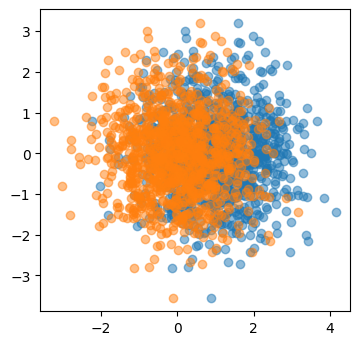

In [16]:
#scatter plot of a subsample of outputs
plt.figure(dpi=100, figsize=(4,4))
cut1 = outputs_bias[0][0,:]
cut2 = outputs_nobias[0][0,:]
plt.scatter(np.real(cut1), np.imag(cut1), alpha=0.5)
plt.scatter(np.real(cut2), np.imag(cut2), alpha=0.5)

In [18]:
#rearrange the data and place it in a dataframe
xs = np.concatenate((np.real(outputs_bias[0]).ravel(), np.real(outputs_nobias[0]).ravel()))
ys = np.concatenate((np.imag(outputs_bias[0]).ravel(), np.imag(outputs_nobias[0]).ravel()))
n = outputs_bias[0].ravel().shape[0]
labels = np.concatenate((np.repeat("Bias", n), np.repeat("No Bias", n)))

In [19]:
data = pd.DataFrame({
    "Real" : xs,
    "Imaginary" : ys,
    "Type" : labels,

})

<AxesSubplot:xlabel='Real', ylabel='Imaginary'>

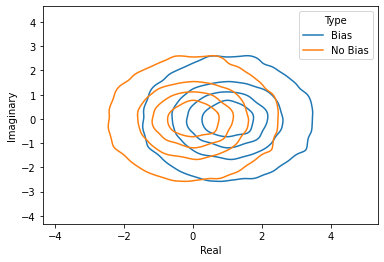

In [20]:
#plot a density estimation plot with seaborn
sns.kdeplot(data = data, x = "Real", y = "Imaginary", hue="Type", levels=5)

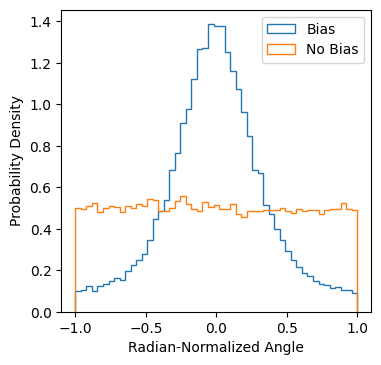

In [21]:
#plot a histogram of the activations (angles) of the complex sums
plt.figure(dpi=100, figsize=(4,4))
plt.hist(np.array(outputs_bias[1]).ravel(), bins=51, density=True, histtype='step', label="Bias")
plt.hist(np.array(outputs_nobias[1]).ravel(), bins=51, density=True, histtype='step', label="No Bias");
plt.xlabel("Radian-Normalized Angle")
plt.ylabel("Probability Density")
plt.legend()